### Calcolo funzioni di autocorrelazione mediando su tutto il database (separatamente per ogni rho) più calcolo std

In [140]:
import glob
paths = glob.glob('/scratch/scarpolini/databases/db_lorenz_*.npy')

aaacf = np.ndarray(shape=(2,3,sig_len))
for path in paths:
    r = float(path[-8:-4])
    db = np.load(path)
    sig_len = len(db[0,0,:])
    n_traj = len(db[:,0,0])
    aacf = np.ndarray(shape=(n_traj,3,sig_len))
    aacf[:,:,:] = 0.0
    print(f'sig_len={sig_len} n_traj={n_traj} r={r}')
    
    def acf(x):
        result = np.correlate(x, x, mode='full')
        return result[result.size // 2:] / result[result.size // 2:].max()
    
    for traj, ii in zip(db, range(n_traj)):
        a = traj[0,:]
        b = traj[1,:]
        c = traj[2,:]
        a -= np.mean(a)
        b -= np.mean(b)
        c -= np.mean(c)
        aacf[ii,0,:] = acf(a)
        aacf[ii,1,:] = acf(b)
        aacf[ii,2,:] = acf(c)
    
    aaacf[:,:,:] = 0.0
    aaacf[0,:,:] = np.mean(aacf, axis=0)
    aaacf[1,:,:] = np.std(aacf, axis=0)
        
    np.save(f'/scratch/scarpolini/databases/acfe_lorenz_{r:.1f}', aaacf)
    
    

sig_len=2000 n_traj=50000 r=20.0
sig_len=2000 n_traj=50000 r=22.0
sig_len=2000 n_traj=50000 r=24.0
sig_len=2000 n_traj=50000 r=26.0
sig_len=2000 n_traj=50000 r=28.0
sig_len=2000 n_traj=50000 r=30.0
sig_len=2000 n_traj=50000 r=15.0
sig_len=2000 n_traj=50000 r=17.0
sig_len=2000 n_traj=50000 r=23.0
sig_len=2000 n_traj=50000 r=25.0
sig_len=2000 n_traj=50000 r=31.0
sig_len=2000 n_traj=50000 r=27.0
sig_len=2000 n_traj=50000 r=29.0
sig_len=2000 n_traj=50000 r=35.0
sig_len=2000 n_traj=50000 r=40.0
sig_len=2000 n_traj=50000 r=12.0
sig_len=2000 n_traj=50000 r=14.0
sig_len=2000 n_traj=50000 r=10.0
sig_len=2000 n_traj=50000 r=16.0
sig_len=2000 n_traj=50000 r=18.0
sig_len=2000 n_traj=50000 r=32.0
sig_len=2000 n_traj=50000 r=36.0
sig_len=2000 n_traj=50000 r=34.0
sig_len=2000 n_traj=50000 r=38.0
sig_len=2000 n_traj=50000 r=44.0
sig_len=2000 n_traj=50000 r=46.0
sig_len=2000 n_traj=50000 r=42.0
sig_len=2000 n_traj=50000 r=48.0
sig_len=2000 n_traj=50000 r=50.0
sig_len=2000 n_traj=50000 r=52.0
sig_len=20

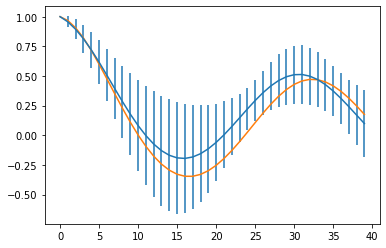

In [138]:
#mm = np.mean(aacf, axis=0)
#ss = np.std(aacf, axis=0)
n = round(np.random.uniform(n_traj))
xlim = 40
import matplotlib.pyplot as plt
plt.errorbar(range(xlim),mm[0,:xlim],yerr=ss[0,:xlim])
plt.plot(aacf[n,0,:xlim])

### Calcolo funzioni di autocorrelazione mediando su tutto il database (separatamente per ogni rho)

In [ ]:
#import glob
#paths = glob.glob('/scratch/scarpolini/databases/db_lorenz_*.npy')
#
#for path in paths:
#    r = float(path[-8:-4])
#    db = np.load(path)
#    sig_len = len(db[0,0,:])
#    acf_tot = np.ndarray(shape=(3,sig_len))
#    acf_tot[:,:] = 0.0
#    n_traj = len(db[:,0,0])
#    print(f'sig_len={sig_len} n_traj={n_traj} r={r}')
#    
#    def acf(x):
#        result = np.correlate(x, x, mode='full')
#        return result[result.size // 2:] / result[result.size // 2:].max()
#    
#    for traj in db:
#        a = traj[0,:]
#        b = traj[1,:]
#        c = traj[2,:]
#        a -= np.mean(a)
#        b -= np.mean(b)
#        c -= np.mean(c)
#        acf_tot[0,:] += acf(a)
#        acf_tot[1,:] += acf(b)
#        acf_tot[2,:] += acf(c)
#    
#    acf_tot /= n_traj
#    
#    ######np.save(f'/scratch/scarpolini/databases/acf_lorenz_{r:.1f}', acf_tot)

sig_len=2000 n_traj=50000 r=20.0


/usr/local/tensorflow/1.14-0/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


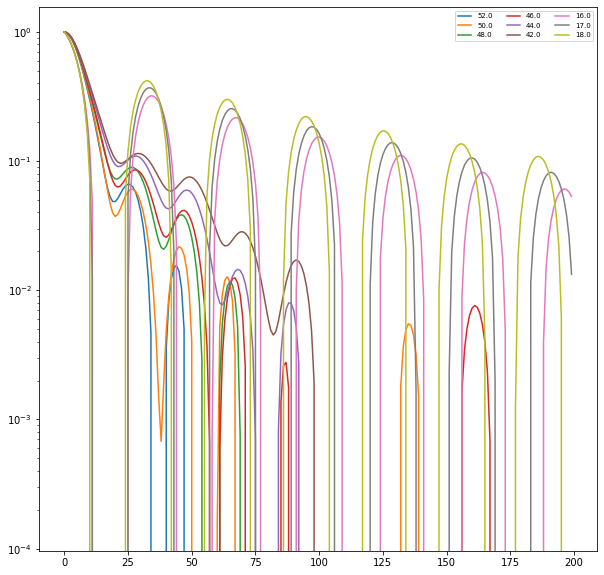

In [67]:
import numpy as np
import glob
paths = glob.glob('/scratch/scarpolini/databases/acf_lorenz_*.npy')
paths = sorted(paths, key=lambda x : float(x[-8:-4]))
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
#rv = [30, 32, 34, 36, 38, 40 , 42, 44, 46, 48, 50, 52, 54, 58]
#for r in rv:

figure(figsize=(10,10))
for path in paths[-4:-10:-1]:
    r = float(path[-8:-4])
    acf = np.load(path)
    #acf = np.load(f'/scratch/scarpolini/databases/acf_lorenz_{r:.1f}.npy')
    plt.plot(acf[0,:200], label=str(r))
plt.yscale('log')
#plt.xscale('log')
#plt.ylim([1.e-1,2.])
plt.legend(ncol=3, fontsize='x-small')

for path in paths[4:7]:
    r = float(path[-8:-4])
    acf = np.load(path)
    #acf = np.load(f'/scratch/scarpolini/databases/acf_lorenz_{r:.1f}.npy')
    plt.plot(acf[0,:200], label=str(r))
plt.yscale('log')
#plt.xscale('log')
#plt.ylim([1.e-1,2.])
plt.legend(ncol=3, fontsize='x-small')

### Creo lista dei path e carico i databases

In [21]:
import numpy as np

rv = [14.0, 26.0, 36.0, 58.0]
nr = len(rv)
paths = []
for r in rv:
    paths.append(f"/scratch/scarpolini/databases/db_lorenz_{r:.1f}.npy")
print(paths)

dbs = []
for path in paths:
    dbs.append(np.load(path))

['/scratch/scarpolini/databases/db_lorenz_14.0.npy', '/scratch/scarpolini/databases/db_lorenz_26.0.npy', '/scratch/scarpolini/databases/db_lorenz_36.0.npy', '/scratch/scarpolini/databases/db_lorenz_58.0.npy']


### Calcolo funzioni di autocorrelazione di una singola traiettoria e la confronto con quella mediata su tutto il suo database

In [31]:
def acf(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size // 2:] / result[result.size // 2:].max()

xlim = 20
import matplotlib.pyplot as plt
for db, r, ii in zip(dbs, rv, range(nr)):
    acf_tot = abs(np.load(f'/scratch/scarpolini/databases/acf_lorenz_{r:.1f}.npy')[0,:])
    n = round(np.random.uniform(len(db[:,0,0])))
    a = db[n,0,:]
    a = a - np.mean(a)
    #b = db[n,1,:]
    #b = b - np.mean(b)
    #c = db[n,2,:]
    #c = c - np.mean(c)
    acfx = abs(acf(a))   ## ATTENZIONE: STO PLOTTANDO IL MODULO DELLA FUNZIONE DI AUTOCORRELAZIONE
    #acfy = acf(b)
    #acfz = acf(c)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,5))
    ax1.plot(a, color="g", label=f"r ={r}")
    #ax1.plot(b, color="b")
    #ax1.plot(c, color="r")
    ax2.plot(acfx[:xlim], color="g", label=f"r ={r}", marker=".", markevery=5)
    #ax2.plot(acfy, color="b")
    #ax2.plot(acfz, color="r")
    
    ax2.plot(acf_tot[:xlim], color="r", marker="v", markevery=5, label=f'r={r}, mediato')
    
    ax2.set_yscale('log')
    #ax2.set_xscale('log')
    ax2.set_ylim([1.e-3,2.])
    plt.legend()


NameError: name 'dbs' is not defined

## Prova riconoscimento parametro dalla funzione di autocorrelazione

In [77]:
import numpy as np
def acf(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size // 2:] / result[result.size // 2:].max()

import glob
paths = glob.glob('/scratch/scarpolini/databases/acf_lorenz_*.npy')
paths = sorted(paths, key=lambda x : float(x[-8:-4]))

def all_parameters(paths):
    result = []
    for path in paths :
        result.append(float(path[-8:-4]))
    return result

parameters = all_parameters(paths)
nn = round(np.random.uniform(len(paths)))
r = parameters[nn]
db = np.load(f"/scratch/scarpolini/databases/db_lorenz_{r:.1f}.npy")
path = paths[nn]
r

34.0

In [78]:
n = round(np.random.uniform(50000))

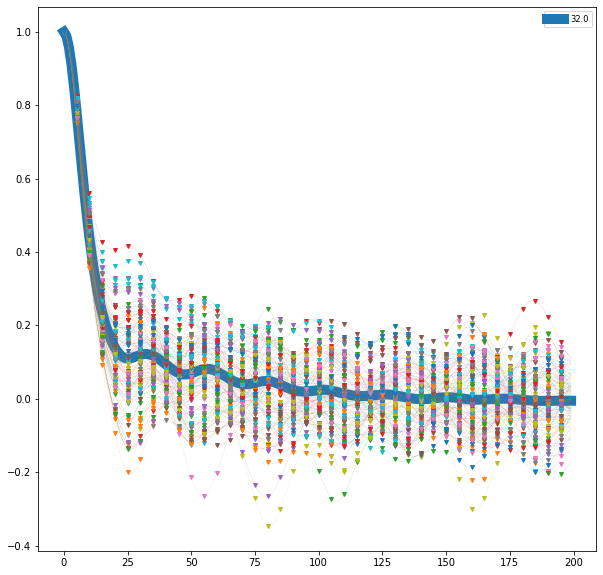

In [85]:
xlim = 200
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(10,10))
#for path in paths[10:20:1]:
#    rr = float(path[-8:-4])
acf_tot = np.load(path)
    #acf = np.load(f'/scratch/scarpolini/databases/acf_lorenz_{r:.1f}.npy')
plt.plot(acf_tot[0,:xlim], label=str(rr), lw=10)
#plt.yscale('log')
#plt.xscale('log')
#plt.ylim([1.e-1,2.])
plt.legend(ncol=3, fontsize='small')

for ii in range(100):
    n = round(np.random.uniform(50000))
    a = db[n,0,:]
    a = a - np.mean(a)
    #b = db[n,1,:]
    #b = b - np.mean(b)
    #c = db[n,2,:]
    #c = c - np.mean(c)
    acfx = acf(a)[:xlim]   ## ATTENZIONE: STO PLOTTANDO IL MODULO DELLA FUNZIONE DI AUTOCORRELAZIONE
    #acfy = acf(b)
    #acfz = acf(c)
    plt.plot(acfx, marker='v', markevery=5, ms=4, lw=0.1)
plt.show()

In [49]:
r

32.0